# Pruebas con el filtro de días
Una vez nos hemos quedado solo con aquellas temperaturas que están entre 35.7ºC y 37.7ºC (para todas las series), filtramos ahora las series temporales manteniendo sólo las que tengan datos en todos los días dentro de un rango determinado alrededor de la ovulación

In [12]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import pickle
import plotly.graph_objects as go
import math

In [13]:
NUM_SERIES_ESTUDIO = 5 # Número de series temporales más representarivas que queremos visualizar
RANGE_VISUALIZ = [35.0, 38.0] # Rango de temperaturas para la visualización

DIAS_REQUERIDOS_ANTES = 2 # Días antes de la ovulación que exigimos que tengan datos para considerar la serie
DIAS_REQUERIDOS_DESPUES = 5 # Días después de la ovulación que exigimos que tengan datos para considerar la serie

UMBRAL_DATOS_POR_DIA = 1  # Al menos 1 dato por día

fecha_ref = pd.Timestamp('2025-01-01 00:00:00').floor('h') # Para alinear las gráficas

### Cargar los datos

In [14]:
# Cargamos los datos de las muestras de ovulación con valores entre [35.7, 37.7]
with open("../procData/muestras_ovul_filt.pkl", "rb") as f:
    muestras_ovul = pickle.load(f)

In [15]:
# Recogemos los nombres de las series temporales con las que trabajamos
name_series = muestras_ovul.keys()
len(name_series)

122

In [16]:
# Función para mostrar gráficamente las series temporales de list_ids con matplotlib
def print_series(list_ids):

    for id in list_ids:
        serie = muestras_ovul[id]["serie"]

        # Convertimos las fechas a días relativos a la ovulación
        x = (serie["resultTimestamp"] - fecha_ref) / pd.Timedelta(days=1)
        y = serie["result"]

        plt.figure(figsize=(8, 4))

        # Puntos de la serie
        plt.scatter(x, y, s=10, label=f'Serie {id}', alpha=0.8)

        # Línea vertical discontinua en el día 0 (ovulación)
        plt.axvline(x=0, color='red', linestyle='--', linewidth=2)
        #plt.text(0, 38.7, 'Ovulación', color='red', ha='center', va='bottom')

        # Etiquetas y título
        plt.title(f'Serie {id}')
        plt.xlabel('Día relativo a la ovulación')
        plt.ylabel('Temperatura (°C)')
        plt.grid(True)

        plt.ylim(RANGE_VISUALIZ[0], RANGE_VISUALIZ[1])  

        plt.tight_layout()
        plt.show()


In [17]:
# Función para mostrar gráficamente las series temporales de list_ids con pyplot (puede hacerse zoom)
def print_series_zoom(list_ids):

    for id in list_ids:
        serie = muestras_ovul[id]["serie"]

        fig = go.Figure()

        fig.add_trace(go.Scatter(
            x=(serie["resultTimestamp"] - fecha_ref) / pd.Timedelta(days=1),
            y=serie["result"],
            mode='markers',
            name=id,
            marker=dict(size=4),
            line=dict(width=1)
        ))

        # Línea vertical discontinua en el día 0 (ovulación)
        fig.add_shape(
            type="line",
            x0=0,
            y0=35.5,
            x1=0,
            y1=37.7,
            line=dict(color="red", width=2, dash="dash")
        )

        fig.add_annotation(
            x=0,
            y=38.0,
            text="Ovulación",
            showarrow=False,
            yanchor="bottom",
            font=dict(color="red")
        )

        fig.update_layout(
            title=f"Serie {id}",
            xaxis_title="Día relativo a la ovulación",
            yaxis_title="Temperatura",
            hovermode="x unified",
            template="plotly_white",
            height=400
        )

        fig.update_yaxes(range=RANGE_VISUALIZ)

        fig.show()

In [18]:
# Filtramos las series temporales para quedarnos con aquellas que tienen al menos un dato por dia en el rango alrededor de la ovulación

series_filtradas = {}

for id_muestra, muestra in muestras_ovul.items():
    serie = muestra["serie"].copy()

    # Calculamos el dia relativo a la ovulación
    serie["dia_relativo"] = ((serie["resultTimestamp"] - fecha_ref) / pd.Timedelta(days=1)).astype(int)

    # Contamos cuántos datos no nulos hay por dia
    conteo_por_dia = serie.dropna(subset=["result"]).groupby("dia_relativo").size()

    # Comprobamos si hay al menos un dato en cada dia de [-5, 5]
    dias_necesarios = list(range(-DIAS_REQUERIDOS_ANTES, DIAS_REQUERIDOS_DESPUES + 1))

    if all(dia in conteo_por_dia.index for dia in dias_necesarios):
        series_filtradas[id_muestra] = muestra

In [ ]:
# Generamos los nombres de las series filtradas
name_series_filt = series_filtradas.keys()
len(name_series_filt)
# Vemos que hay 61 series temporales tras el filtrado

61

In [27]:
# Calculamos, para cada serie de las filtradas, cuántos datos no nulos hay
numero_nulos_filt = [(id, series_filtradas[id]["serie"]["result"].isna().sum()) for id in name_series_filt]

# Ordenamos de mayor a menor cantidad de valores no nulos
numero_nulos_filt.sort(key=lambda x: x[1], reverse=False)

In [28]:
[(id, float(n/14401)) for (id, n) in numero_nulos_filt]

[('TU046_3', 0.005138532046385667),
 ('TU078_1', 0.019373654607318935),
 ('TU074_4', 0.05694049024373307),
 ('TU021_1', 0.06534268453579613),
 ('TU013_2', 0.0655510034025415),
 ('AN003_1', 0.07471703353933755),
 ('AN001_3', 0.08027220331921395),
 ('TU030_2', 0.08152211651968613),
 ('TU046_1', 0.09047982778973683),
 ('TU063_2', 0.10242344281647107),
 ('TU023_2', 0.10645094090688147),
 ('TU067_2', 0.11395042010971461),
 ('AN010_3', 0.11797791820012499),
 ('AN002_2', 0.11839455593361572),
 ('TU074_2', 0.11922783140059719),
 ('TU074_3', 0.11922783140059719),
 ('TU038_1', 0.12290813137976529),
 ('TU080_1', 0.12492188042497049),
 ('TU060_2', 0.12881049927088398),
 ('TU054_1', 0.12957433511561697),
 ('AN008_1', 0.13422678980626346),
 ('AN009_3', 0.13436566905076036),
 ('TU038_2', 0.13915700298590375),
 ('TU046_2', 0.1637386292618568),
 ('TU017_1', 0.1643635858620929),
 ('TU036_4', 0.1682522047080064),
 ('TU063_3', 0.16929379904173322),
 ('TU023_1', 0.18818137629331297),
 ('TU019_2', 0.1923477

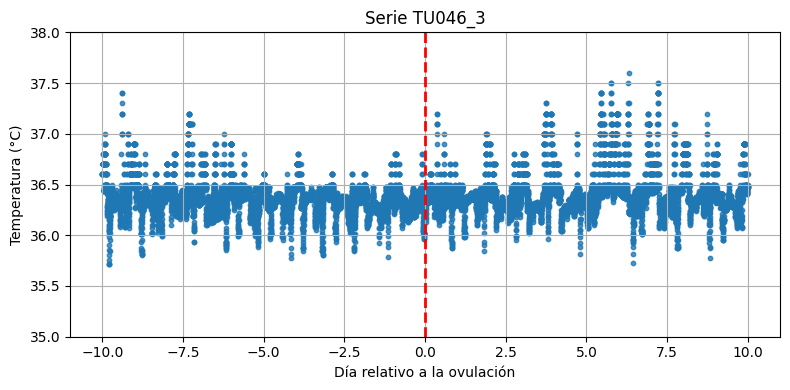

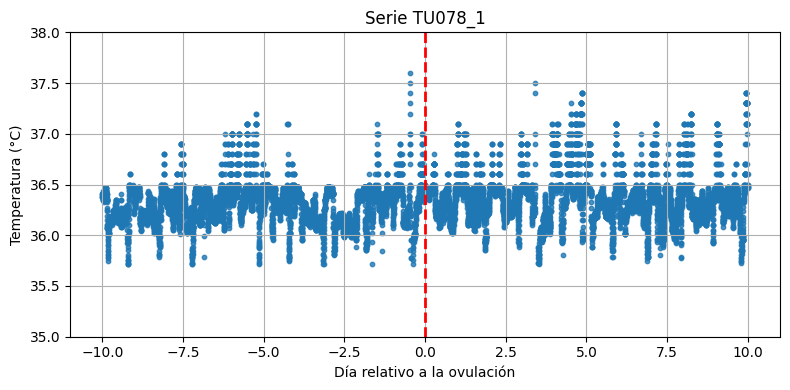

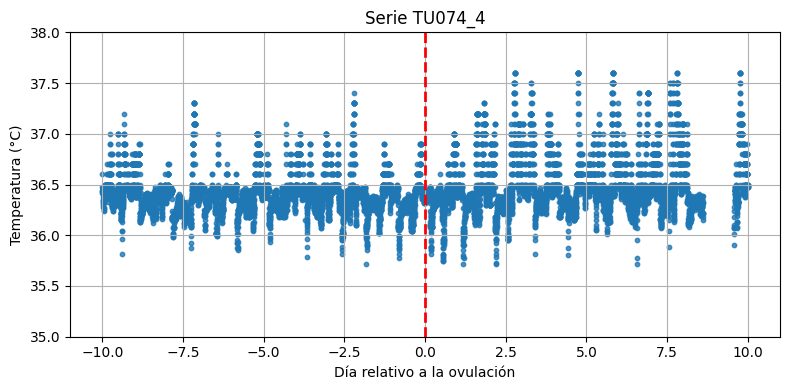

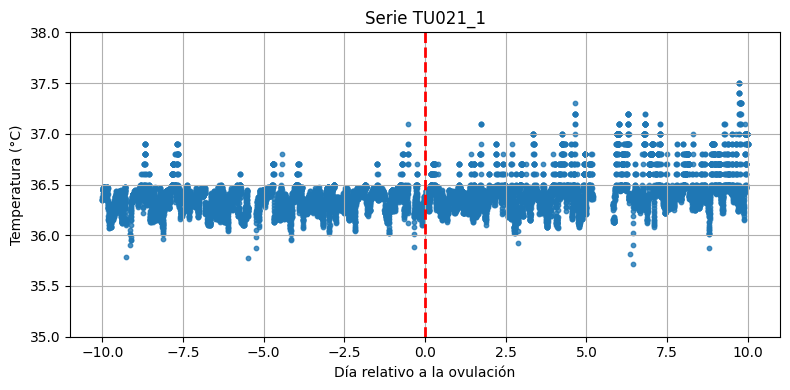

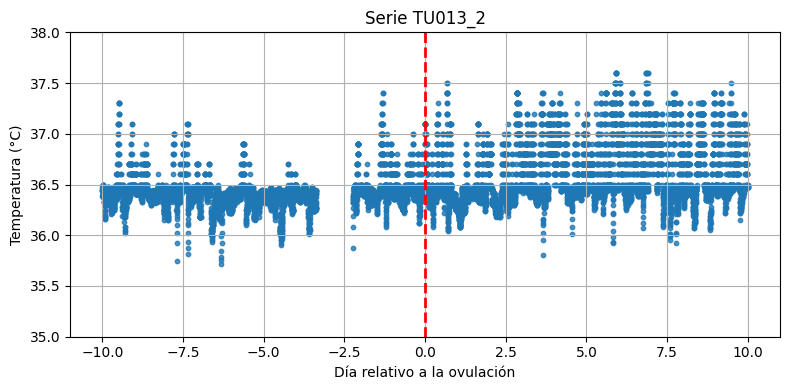

In [24]:
# Las representamos gráficamente
ids_estudio = [id for (id, n) in numero_nulos_filt[:NUM_SERIES_ESTUDIO]]
print_series(ids_estudio)

In [ ]:
print_series_zoom(ids_estudio)

In [22]:
with open("../procData/muestras_ovul_filt2.pkl", "wb") as f:
    pickle.dump(series_filtradas, f)